In [1]:
import os
import pathlib
import pandas as pd
from sklearn.metrics import classification_report
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
!pip install ktrain
import ktrain
from ktrain import text

     |████████████████████████████████| 25.2 MB 3.1 MB/s 
     |████████████████████████████████| 981 kB 48.2 MB/s 
     |████████████████████████████████| 241 kB 50.9 MB/s 
     |████████████████████████████████| 3.3 MB 46.8 MB/s 
     |████████████████████████████████| 468 kB 42.4 MB/s 
  Created wheel for ktrain: filename=ktrain-0.14.7-py3-none-any.whl size=25240972 sha256=823d911b02ff3727a0c7f3f3a24a000ba30291778d1bf4e35e6f2980542088be
  Stored in directory: /root/.cache/pip/wheels/d5/f8/64/c482e2e11303d04d85af01b9b94ecfbeff8620be8f6e543e5f
  Created wheel for keras-bert: filename=keras_bert-0.81.0-py3-none-any.whl size=37912 sha256=195e68bee85bccad2266536b054449ba80888844d1512b69a6d9547fad1aa68d
  Stored in directory: /root/.cache/pip/wheels/fc/f6/94/9c54242cde921a3cdc7d049bae3f137d21fa28d3b8ccefd8a0
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=04f1d9b3b21e118418b9161bdc680c83ec670bd6c5140bf812cb61ee7803e731
  Stored in directory: /

In [3]:
#check if the paths for the input data is valid.
train_path="../input/sentimentdatasets/trainJira.csv"
test_path="../input/sentimentdatasets/testJira.csv"
tr_path= pathlib.Path(train_path)
te_path=pathlib.Path(test_path)
if tr_path.exists ():
    print("Train data path set.")
else: 
    raise SystemExit("Train data path does not exist.")
     
if te_path.exists ():
    print("Test data path set.")
else: 
    raise SystemExit("Test data path does not exist.")
     

Train data path set.
Test data path set.


In [4]:
#showing the first 5 lines of the train data
train_df=pd.read_csv(train_path, encoding="utf-16", header=None)
train_df.head()


,0,1,2
0,409,I'm backporting this to 3.4 and 3.3 branches. ...,neutral
1,485,+1 overall. Here are the results of testing th...,neutral
2,611,Bug Flavio more? Seriously,negative
3,644,Integrated in ZooKeeper-trunk #1266 (See https...,neutral
4,927,The patch no longer applies. Abmar,neutral


In [5]:
#showing the first 5 lines of the test data
test_df=pd.read_csv(test_path, encoding="utf-16", header=None)
test_df[2]=test_df[2].astype(str)
test_df.head()


,0,1,2
0,180,neutral,Jimmy this ready for review/commit? If so plea...
1,2091,neutral,Edited these issues to set the fix version.
2,2685,neutral,Integrated in Hadoop-Mapreduce-trunk #1386 (Se...
3,2987,positive,Thanks for the patch
4,3399,neutral,Changed MULTI_TEXTVALUE_SEPARATOR into a prope...


In [6]:
(x_train, y_train), (x_test, y_test), preproc =  text.texts_from_array(train_df[1], train_df[2],  x_test=test_df[2], y_test=test_df[1], maxlen=500, preprocess_mode='bert')
                                                                     
                  

task: text regression (supply class_names argument if this is supposed to be classification task)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [7]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


In [8]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

In [9]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 4110 samples
Epoch 1/1024
4110/4110 [==============================] - 559s 136ms/sample - loss: 0.7464 - accuracy: 0.6820
Epoch 2/1024
3210/4110 [======================>.......] - ETA: 1:58 - loss: 0.9960 - accuracy: 0.6514

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


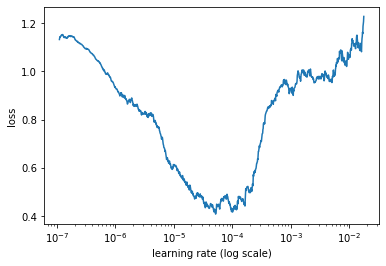

In [10]:
learner.lr_plot()

In [11]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.autofit(2e-5, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Train on 4110 samples, validate on 1759 samples
Epoch 1/1024
4110/4110 [==============================] - 588s 143ms/sample - loss: 0.4850 - accuracy: 0.8054 - val_loss: 0.3347 - val_accuracy: 0.8738
Epoch 2/1024
4110/4110 [==============================] - 588s 143ms/sample - loss: 0.2852 - accuracy: 0.8981 - val_loss: 0.3392 - val_accuracy: 0.8715
Epoch 3/1024
4104/4110 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9247
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
4110/4110 [==============================] - 587s 143ms/sample - loss: 0.2077 - accuracy: 0.9248 - val_loss: 0.3524 - val_accuracy: 0.8658
Epoch 4/1024
4110/4110 [==============================] - 585s 142ms/sample - loss: 0.1217 - accuracy: 0.9545 - val_loss: 0.3845 - val_accuracy: 0.8744
Epoch 5/1024
4104/4110 [=========

In [12]:
model.save("jira_model.h5")

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [14]:
data=test_df[2].tolist()
label=test_df[1].tolist()

In [15]:
i=0
correct=0
wrong=0
total=len(data)
true_lab=[]
pred_lab=[]
text=[]
for dt in data:
    result=predictor.predict(dt)
    if not result== label[i]:
        text.append(dt)
        pred_lab.append(result)
        true_lab.append(label[i])
        wrong+=1
    else:
        correct+=1
    
    i+=1

name_dict = {
            'Name': text,
            'Gold Label' : true_lab,
            'Predicted Label': pred_lab
          }

wrong_data= pd.DataFrame(name_dict)

wrong_data.to_csv("wrong_results.csv", sep=';')   
    
    

In [16]:
names = ['negative', 'neutral', 'positive']
y_pred = predictor.predict(data)
y_true= test_df[1]
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

    negative       0.85      0.68      0.76       235
     neutral       0.92      0.89      0.91      1186
    positive       0.76      0.94      0.84       338

    accuracy                           0.87      1759
   macro avg       0.84      0.84      0.83      1759
weighted avg       0.88      0.87      0.87      1759



In [17]:
print("Correct: ", correct,"/",total,"\nWrong: ", wrong,"/",total)

Correct:  1537 / 1759 
Wrong:  222 / 1759
